# 1. IMPOTACIÓN DE LIBRERÍAS

In [1]:
import os # Librería para acceder a variables del sistema
import time # Librería para contabilizar la duración del entrenamiento de cada modelo de CNN
import numpy as np # Librería empleada para operaciones de array
from os import path # Librería empleada para comprobar que existen ciertos archivos y directorios
import pandas as pd # Para gestionar datos por medio de dataframes
from os import listdir # Librería del sistema empleada para leer archivos o directorios
import seaborn as sns # Librería para realizar mapas de calor (heatmap) con matrices de confusión con sus porcentajes
import tensorflow as tf # Librería de Machine Learning
from sklearn import metrics # Para obtener métricas de los modelos de clasificación
from  matplotlib import image # Librería empleada para importar una imagen como un vector
from skimage import transform # Para modificar las dimensiones de las imágenes y así unificarlas
from keras import backend as K # backend from keras
import matplotlib.pyplot as plt # Para generar gráficos y figuras
from tensorflow import keras as k # Módulo de keras de tensorflow
from keras.utils import plot_model # Para generar un diagrama con la arquitectura del modelo de CNN construido
from keras.models import Sequential # Función de keras para inicializar un modelo secuencial
from keras.utils import to_categorical # Función de keras para obtener la matriz codificada
# mediante one-hot en el caso de la clasificación binaria
from keras.callbacks import EarlyStopping # Módulo de Early Stopping de keras
from sklearn.model_selection import train_test_split # Empleado para dividir los datos de entrenamiento en datos de entrenamiento y de validación
from tensorflow.keras.optimizers import Adam # Se importa el optimizador adam
from keras.layers import Conv2D, Flatten, Dense, Input, AveragePooling2D, Dropout, MaxPooling2D # capas para añadir
# en el modelo secuencial de keras
from tensorflow.keras.callbacks import LearningRateScheduler # Se importa el planificador del learning rate decay

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' # '0' = Everything, '1' = Warnings, '2' = Errors, '3' = Fatal
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True # Permitir el uso de más memoria de gpu dependiendo de la demanda de la ejecución

session = tf.compat.v1.Session(config=config) # Se establece la configuración previa

2023-06-04 16:28:29.825251: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-04 16:28:30.217957: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-06-04 16:28:31.327760: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/carlos/miniconda3/envs/tfm/lib/
2023-06-04 16:28:31.331934: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plug

In [2]:
# Se muestran las unidades de CPU y GPU disponibles en el entorno actual
print("Num CPUs disponibles: ", len(tf.config.list_physical_devices('CPU')))
print("CPU disponible: ", tf.config.list_physical_devices('CPU'))

print("Num GPUs disponibles: ", len(tf.config.list_physical_devices('GPU')))
print("GPU disponible: ", tf.config.list_physical_devices('GPU'))
tf.config.experimental.list_physical_devices()

Num CPUs disponibles:  1
CPU disponible:  [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]
Num GPUs disponibles:  1
GPU disponible:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2023-06-04 16:28:34.116393: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-06-04 16:28:34.116649: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-06-04 16:28:34.116709: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# 2. INICIALIZACIÓN DE VARIABLES

In [3]:
# Se inicializan a una lista vacía las variables donde se almacenarán tanto las imágenes como las etiquetas de cada conjunto, es decir, de los conjuntos de entrenamiento, validación y test
train_images = [] # list where images for training will be saved
train_targets = [] # list where labels for the corresponding training images will be saved

val_images = [] # list where images for val will be saved
val_targets = [] # list where labels for the corresponding val images will be saved

test_images = [] # list where images for test will be saved
test_targets = [] # list where labels for the corresponding test images will be saved

# 3. LECTURA DE IMÁGENES DEL DATASET (TRAIN-VAL-TEST)

In [4]:
# Ubicación de las imágenes MRI de cerebros con HSVE

class_HSVE_path = './DATASET/DATASET_Modelos1_2_3_4_5_6/HSVE_ORIGINAL_ALL_TYPES_RESCALED_256/' # Ubicación remota las imágenes MRI de la clase positiva (cerebros con la enfermedad HSVE)

print('TRAIN PATH: ', class_HSVE_path) # Se visualiza el path de esta fracción del dataset (clase1)

TRAIN PATH:  ./DATASET/DATASET_Modelos1_2_3_4_5_6/HSVE_ORIGINAL_ALL_TYPES_RESCALED_256/


In [5]:
# Ubicación de las imágenes MRI de cerebros sanos

class_HealthyBrains_path = './DATASET/DATASET_Modelos1_2_3_4_5_6/HEALTHY_BRAINS_ALL_TYPES_RESCALED_256/' # Ubicación remota las imágenes MRI de la clase negativa (cerebros sanos)

print('TRAIN PATH: ', class_HealthyBrains_path) # Se visualiza el path de esta fracción del dataset (clase0)

TRAIN PATH:  ./DATASET/DATASET_Modelos1_2_3_4_5_6/HEALTHY_BRAINS_ALL_TYPES_RESCALED_256/


In [6]:
# Lectura de todas las imágenes MRI de cerebros con HSVE tanto del conjunto de entrenamiento como del conjunto
# de validación y de test. Para cada imagen leida se convierten cada uno de los píxeles de la imagen al tipo
# numérico de coma flotante 'float32', se aplica una normalización estándar sobre la imagen para que
# cada una tenga una media de 0 y una desviación estándar de 1 y se asigna la etiqueta
# de la clase en cuestión. En este caso la se asigna la etiqueta 1 al tratarse de imágenes MRI de cerebros con HSVE

for folder1 in listdir(class_HSVE_path):
    if path.isdir(class_HSVE_path + folder1):
        for folder2 in listdir(class_HSVE_path + folder1):
            if path.isdir(class_HSVE_path + folder1 + '/' + folder2):
                for folder3 in listdir(class_HSVE_path + folder1 + '/' + folder2):
                    if path.isdir(class_HSVE_path + folder1 + '/' + folder2 + '/' + folder3):
                        for filename in listdir(class_HSVE_path + folder1 + '/' + folder2 + '/' + folder3):
                            print(filename)
                            if path.isfile(class_HSVE_path + folder1 + '/' + folder2 + '/' + folder3 + '/' + filename) and filename != '.DS_Store' and filename != '._.DS_Store':

                                img = image.imread(class_HSVE_path + folder1 + '/' + folder2 + '/' + folder3 + '/' + filename)

                                img = img.astype(np.float32) # Se convierte la imagen a punto flotante de 32 bits

                                imagen_normalized = (img - np.mean(img)) / np.std(img) # Se aplica una normalización estándar a cada imagen

                                if(folder1 == 'training_set'):

                                    train_images.append(imagen_normalized)
                                    train_targets.append(1)

                                    print("IMAGEN TRAIN LEÍDA: ", filename, " | LABEL: ", 1)

                                if(folder1 == 'validation_set'):

                                    val_images.append(imagen_normalized)
                                    val_targets.append(1)

                                    print("IMAGEN VALIDATION LEÍDA: ", filename, " | LABEL: ", 1)

                                if(folder1 == 'test_set'):

                                    test_images.append(imagen_normalized)
                                    test_targets.append(1)

                                    print("IMAGEN TEST LEÍDA: ", filename, " | LABEL: ", 1)

                                print(type(imagen_normalized))
                                print("SHAPE: ", imagen_normalized.shape)

num_HSVE_train = len(train_images)
num_HSVE_val = len(val_images)
num_HSVE_test = len(test_images)
print()
print("Número de imágenes de ENTRENAMIENTO LEÍDAS de la clase 1:", num_HSVE_train)
print("Número de imágenes de VALIDACIÓN LEÍDAS de la clase 1:", num_HSVE_val)
print("Número de imágenes de TEST LEÍDAS de la clase 1:", num_HSVE_test)

hsv-encephalitis-9(1).jpeg
IMAGEN TEST LEÍDA:  hsv-encephalitis-9(1).jpeg  | LABEL:  1
<class 'numpy.ndarray'>
SHAPE:  (256, 256)
hsv-encephalitis-9(10).jpeg
IMAGEN TEST LEÍDA:  hsv-encephalitis-9(10).jpeg  | LABEL:  1
<class 'numpy.ndarray'>
SHAPE:  (256, 256)
hsv-encephalitis-9(11).jpeg
IMAGEN TEST LEÍDA:  hsv-encephalitis-9(11).jpeg  | LABEL:  1
<class 'numpy.ndarray'>
SHAPE:  (256, 256)
hsv-encephalitis-9(12).jpeg
IMAGEN TEST LEÍDA:  hsv-encephalitis-9(12).jpeg  | LABEL:  1
<class 'numpy.ndarray'>
SHAPE:  (256, 256)
hsv-encephalitis-9(2).jpeg
IMAGEN TEST LEÍDA:  hsv-encephalitis-9(2).jpeg  | LABEL:  1
<class 'numpy.ndarray'>
SHAPE:  (256, 256)
hsv-encephalitis-9(3).jpeg
IMAGEN TEST LEÍDA:  hsv-encephalitis-9(3).jpeg  | LABEL:  1
<class 'numpy.ndarray'>
SHAPE:  (256, 256)
hsv-encephalitis-9(4).jpeg
IMAGEN TEST LEÍDA:  hsv-encephalitis-9(4).jpeg  | LABEL:  1
<class 'numpy.ndarray'>
SHAPE:  (256, 256)
hsv-encephalitis-9(5).jpeg
IMAGEN TEST LEÍDA:  hsv-encephalitis-9(5).jpeg  | LABEL: 

In [7]:
# Lectura de todas las imágenes MRI de cerebros SANOS tanto del conjunto de entrenamiento como del conjunto
# de validación y de test. Para cada imagen leida se convierten cada uno de los píxeles de la imagen al
# tipo numérico de coma flotante 'float32', se aplica una normalización estándar sobre la imagen para que cada
# una tenga una media de 0 y una desviación estándar de 1 y se asigna la etiqueta
# de la clase en cuestión. En este caso la se asigna la etiqueta 0 al tratarse de imágenes MRI de cerebros con HSVE

# Para que las clases sean equilibradas, como máximo se leeran tantas imágenes MRI de cerebros sanos como número de
# imágenes MRI de la enfermedad HSVE se hayan leido en la celda anterior
# Se calculan las imágenes de HSVE leidas en traning, validación y test
num_HSVE_train = len(train_images)
num_HSVE_val = len(val_images)
num_HSVE_test = len(test_images)
num_HEALTHY_train = 0
num_HEALTHY_val = 0
num_HEALTHY_test = 0

for folder1 in listdir(class_HealthyBrains_path):
    if path.isdir(class_HealthyBrains_path + folder1):
        for folder2 in listdir(class_HealthyBrains_path + folder1):
            if path.isdir(class_HealthyBrains_path + folder1 + '/' + folder2):
                for folder3 in listdir(class_HealthyBrains_path + folder1 + '/' + folder2):
                    if path.isdir(class_HealthyBrains_path + folder1 + '/' + folder2 + '/' + folder3):
                        for filename in listdir(class_HealthyBrains_path + folder1 + '/' + folder2 + '/' + folder3):
                            print(filename)
                            if path.isfile(class_HealthyBrains_path + folder1 + '/' + folder2 + '/' + folder3 + '/' + filename) and filename != '.DS_Store' and filename != '._.DS_Store':

                                img = image.imread(class_HealthyBrains_path + folder1 + '/' + folder2 + '/' + folder3 + '/' + filename)

                                img = img.astype(np.float32) # Se convierte la imagen a punto flotante de 32 bits

                                imagen_normalized = (img - np.mean(img)) / np.std(img) # Se aplica una normalización estándar a cada imagen

                                if(folder1 == 'training_set'):

                                    if(num_HEALTHY_train == num_HSVE_train):
                                        break

                                    train_images.append(imagen_normalized)
                                    train_targets.append(0)
                                    num_HEALTHY_train = num_HEALTHY_train + 1

                                    print("IMAGEN TRAIN LEÍDA: ", filename, " | LABEL: ", 0)

                                if(folder1 == 'validation_set'):

                                    if(num_HEALTHY_val == num_HSVE_val):
                                        break

                                    val_images.append(imagen_normalized)
                                    val_targets.append(0)
                                    num_HEALTHY_val = num_HEALTHY_val + 1

                                    print("IMAGEN VALIDATION LEÍDA: ", filename, " | LABEL: ", 0)

                                if(folder1 == 'test_set'):

                                    if(num_HEALTHY_test == num_HSVE_test):
                                        break

                                    test_images.append(imagen_normalized)
                                    test_targets.append(0)
                                    num_HEALTHY_test = num_HEALTHY_test + 1

                                    print("IMAGEN TEST LEÍDA: ", filename, " | LABEL: ", 0)

                                print(type(imagen_normalized))
                                print("SHAPE: ", imagen_normalized.shape)

print()
print("Número de imágenes de ENTRENAMIENTO LEÍDAS de la clase 0:", num_HEALTHY_train)
print("Número de imágenes de VALIDACIÓN LEÍDAS de la clase 0:", num_HEALTHY_val)
print("Número de imágenes de TEST LEÍDAS de la clase 0:", num_HEALTHY_test)

normal-brain-mri-and-venogram(10).jpg
IMAGEN TEST LEÍDA:  normal-brain-mri-and-venogram(10).jpg  | LABEL:  0
<class 'numpy.ndarray'>
SHAPE:  (256, 256)
normal-brain-mri-and-venogram(2).jpg
IMAGEN TEST LEÍDA:  normal-brain-mri-and-venogram(2).jpg  | LABEL:  0
<class 'numpy.ndarray'>
SHAPE:  (256, 256)
normal-brain-mri-and-venogram(3).jpg
IMAGEN TEST LEÍDA:  normal-brain-mri-and-venogram(3).jpg  | LABEL:  0
<class 'numpy.ndarray'>
SHAPE:  (256, 256)
normal-brain-mri-and-venogram(4).jpg
IMAGEN TEST LEÍDA:  normal-brain-mri-and-venogram(4).jpg  | LABEL:  0
<class 'numpy.ndarray'>
SHAPE:  (256, 256)
normal-brain-mri-and-venogram(5).jpg
IMAGEN TEST LEÍDA:  normal-brain-mri-and-venogram(5).jpg  | LABEL:  0
<class 'numpy.ndarray'>
SHAPE:  (256, 256)
normal-brain-mri-and-venogram(6).jpg
IMAGEN TEST LEÍDA:  normal-brain-mri-and-venogram(6).jpg  | LABEL:  0
<class 'numpy.ndarray'>
SHAPE:  (256, 256)
normal-brain-mri-and-venogram(7).jpg
IMAGEN TEST LEÍDA:  normal-brain-mri-and-venogram(7).jpg  | L

# 4. PRE-PROCESADO DE LOS DATOS

In [8]:
# Se crean los arrays de las imágenes de entrada
X_train = np.asarray(train_images)
X_val = np.asarray(val_images)
X_test = np.asarray(test_images)

# Se crean los arrays de las etiquetas de entrada
train_targets_array = np.asarray(train_targets)
val_targets_array = np.asarray(val_targets)
test_targets_array = np.asarray(test_targets)

# # Codificación de las etiquetas para clasificación multiclase
# # y_labels_train = to_categorical(train_targets_array) # enconding the train labels with the one_hot method
# # y_labels_test = to_categorical(test_targets_array) # enconding the test labels with the one_hot method
#
# # Se divide el conjunto de entrenamiento en training y validation. Además, el parámetro stratify permite asegurar que la
# # proporción de ejemplos en cada clase sea la misma tras haberse realizado la división
# X_train, X_val, y_train, y_val = train_test_split(X_train, train_targets_array, test_size=0.21, shuffle=True, random_state=42, stratify=train_targets_array)

print("Forma de los datos de ENTRENAMIENTO: ", X_train.shape) # data.shape = (289, 256, 256, 1)
print("Forma de las etiquetas de ENTRENAMIENTO: ", train_targets_array.shape) # labels.shape = (289,)
print()

print("Forma de los datos de VALIDACIÓN: ", X_val.shape) # labels.shape = (51, 256, 256, 1)
print("Forma de las etiquetas de VALIDACIÓN: ", val_targets_array.shape) # labels.shape = (51,)
print()

print("Forma de los datos de TEST: ", X_test.shape) # data.shape = (72, 256, 256, 1)
print("Forma de las etiquetas de TEST: ", test_targets_array.shape) # labels.shape = (72,)
print()

Forma de los datos de ENTRENAMIENTO:  (360, 256, 256)
Forma de las etiquetas de ENTRENAMIENTO:  (360,)

Forma de los datos de VALIDACIÓN:  (134, 256, 256)
Forma de las etiquetas de VALIDACIÓN:  (134,)

Forma de los datos de TEST:  (223, 256, 256)
Forma de las etiquetas de TEST:  (223,)



In [9]:
num_clases = 2

contador_clases_training = np.bincount(train_targets_array) # Se cuenta el número de imágenes de cada clase en el conjunto de entrenamiento

# Se imprime el número de imágenes de cada clase en el conjunto de entrenamiento
for i in range(0, num_clases):
    print("Número de ejemplos de la clase",i, " en el conjunto de entrenamiento:", contador_clases_training[i])
print()

contador_clases_validation = np.bincount(val_targets_array) # Se cuenta el número de imágenes de cada clase en el conjunto de validación

# Se imprime el número de imágenes de cada clase en el conjunto de validación
for i in range(0, num_clases):
    print("Número de ejemplos de la clase",i, " en el conjunto de validación:", contador_clases_validation[i])
print()

contador_clases_test = np.bincount(test_targets_array) # Se cuenta el número de imágenes de cada clase en el conjunto de test

# Se imprime el número de imágenes de cada clase en el conjunto de test
for i in range(0, num_clases):
    print("Número de ejemplos de la clase",i, " en el conjunto de test:", contador_clases_test[i])
print()

Número de ejemplos de la clase 0  en el conjunto de entrenamiento: 180
Número de ejemplos de la clase 1  en el conjunto de entrenamiento: 180

Número de ejemplos de la clase 0  en el conjunto de validación: 67
Número de ejemplos de la clase 1  en el conjunto de validación: 67

Número de ejemplos de la clase 0  en el conjunto de test: 104
Número de ejemplos de la clase 1  en el conjunto de test: 119



# 5. Previsualización de los datos de los 3 conjuntos

In [10]:
nombre_clases = {
    0: 'Healthy brains',
    1: 'Brains with HSVE'
}

In [11]:
# Previsualización del training dataset

# max_train = len(X_train)   # número máximo de imágenes del conjunto de entrenamiento
# random_index_train = random.sample(range(max_train), 6)
#
# plt.figure(figsize=(16, 12))#Plots our figures
# for index, i in enumerate(random_index_train):
#     plt.subplot(2, 3, index+1)
#     plt.imshow(X_train[i, :, :], cmap='gray')
#
#     etiqueta = train_targets_array[i]
#     nombre_etiqueta = nombre_clases[etiqueta]
#     plt.title('Etiqueta: {} - ({})'.format(etiqueta, nombre_etiqueta))
#
# plt.show()

In [12]:
# Previsualización del validation dataset

# max_val = len(X_val)   # número máximo de imágenes del conjunto de validación
# random_index_val = random.sample(range(max_val), 6)
#
# plt.figure(figsize=(16, 12))#Plots our figures
# for index, i in  enumerate(random_index_val):
#     plt.subplot(2, 3, index+1)
#     plt.imshow(X_val[i, :, :], cmap='gray')
#
#     etiqueta = train_targets_array[i]
#     nombre_etiqueta = nombre_clases[etiqueta]
#     plt.title('Etiqueta: {} - ({})'.format(etiqueta, nombre_etiqueta))
#
# plt.show()

In [13]:
# Previsualización del test dataset

# max_test = len(X_test)   # número máximo de imágenes del conjunto de test
# random_index_test = random.sample(range(max_test), 6)
#
# plt.figure(figsize=(16, 12))#Plots our figures
# for index, i in  enumerate(random_index_test):
#     plt.subplot(2, 3, index+1)
#     plt.imshow(X_test[i, :, :], cmap='gray')
#
#     etiqueta = train_targets_array[i]
#     nombre_etiqueta = nombre_clases[etiqueta]
#     plt.title('Etiqueta: {} - ({})'.format(etiqueta, nombre_etiqueta))
#
# plt.show()

# 6. CONSTRUCCIÓN DEL MODELO BASE DE CNN (Red Neuronal Convolucional)

In [14]:
 def get_model():

    # creating Keras model
    model = Sequential()

    # model 1

    # Feature learning part
    model.add(Conv2D(32, kernel_size = 3, activation = 'relu', input_shape = (256, 256, 1)))
    model.add(MaxPooling2D(pool_size = (3, 3), strides = (3,3)))
    model.add(Conv2D(64, kernel_size = 3, activation = 'relu'))
    model.add(MaxPooling2D(pool_size = (3, 3), strides = (3, 3)))
    # Classifier part
    model.add(Flatten())
    model.add(Dense(256, activation = 'relu'))
    model.add(Dense(512, activation = 'relu'))
    model.add(Dense(1, activation = 'sigmoid'))

    return model

In [15]:
# Se muestra un resumen de la arquitectura del modleo secuencial de keras definido en la celda anterior
with tf.device('/GPU:0'):
    model_gpu = get_model()
    # showing a summary of the layers and parameters of the model created
    model_gpu.summary()

    # Save the model defined previously
    plot_model(model_gpu, to_file='arquitecturas_modelos/Model1Iteration1_TestModel_ALL_TYPES_DATASET_arquitecture.png', show_shapes=True)

2023-06-04 16:29:02.173378: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-06-04 16:29:02.173724: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-06-04 16:29:02.173829: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-06-04 16:29:02.174489: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-06-04 16:29:02.174530: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1700] Could not ident

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 84, 84, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 82, 82, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 27, 27, 64)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 46656)             0         
                                                                 
 dense (Dense)               (None, 256)               1

# 7. ENTRENAMIENTO DEL MODELO (Training)

In [16]:
# Configuración de la compilación del modelo anterior:
# Se planifica el learning rate mediante la implementación 'Exponential Decay' y se emplea el optimizador 'Adam'

# lr_schedule = k.optimizers.schedules.ExponentialDecay(
#     initial_learning_rate=1e-3,
#     decay_steps=10000,
#     decay_rate=1e-6)
# adam_optimizer = k.optimizers.Adam(learning_rate=lr_schedule)

In [17]:
# Se define un optimizador de tipo 'Adam' con el learning rate por defecto, es decir, con el valor 0.0001
optimizer = Adam(learning_rate=0.0001)

In [18]:
# Se compila el modelo mediante la GPU
with tf.device('/GPU:0'):
    model_gpu.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = ['accuracy','Precision'])
    print("Modelo compilado")

Modelo compilado


In [19]:
# Se define otro callback de 'early stopping' que permita detener el entrenamiento del modelo si el modelo no mejora el valor de su 'val_accuracy' en 5 epochs consecutivas
early_stop_val_accuracy = EarlyStopping(monitor='val_accuracy', patience=10)

In [20]:
# Se define otro callback de 'early stopping' que permita detener el entrenamiento del modelo si el modelo no mejora el valor de su 'val_loss' en 5 epochs consecutivas
early_stop_val_loss = EarlyStopping(monitor='val_loss', patience=10)

In [21]:
# # Define the learning rate scheduler function
# def lr_scheduler(epoch, lr):
#     # Set the initial learning rate
#     lr_init = 0.0001
#     # Set the decay rate
#     decay_rate = 0.1
#     # Calculate the new learning rate for this epoch
#     lr_new = lr_init / (1.0 + decay_rate * epoch)
#     # Print the new learning rate
#     print('Epoch %d: Learning rate is %f' % (epoch+1, lr_new))
#     # Return the new learning rate
#     return lr_new
#
# # Define the learning rate scheduler callback
# lr_callback = LearningRateScheduler(lr_scheduler)

In [22]:
# Se ENTRENA el modelo mediante la GPU
# Se especifican una serie de hiperparámetros tales como las epochs (un máximo de 50), un batch size de 8 para que
# # la GPU sea capaz de almacenar en memoria hasta 8 imágenes a la vez antes de actualizar los parámetros y se
# # especifican los 2 callbacks previamente declarados
with tf.device('/GPU:0'):

    print("Entrenando modelo de CNN...")

    start_time = time.time()

    h = model_gpu.fit(X_train, train_targets_array, epochs = 30, validation_data=(X_val, val_targets_array), batch_size = 16, callbacks=[early_stop_val_accuracy, early_stop_val_loss],  verbose=1) # training method in which data and targets are passed with some specific parameters

    print("Modelo entrenado")

    end_time = time.time()
    training_time = end_time - start_time
    print("Duración del entrenamiento:", int(training_time/60), "minutos y", int(training_time%60), "segundos")

Entrenando modelo de CNN...


2023-06-04 16:29:04.110093: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 94371840 exceeds 10% of free system memory.
2023-06-04 16:29:09.686660: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 94371840 exceeds 10% of free system memory.


Epoch 1/30


2023-06-04 16:29:33.382389: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100
2023-06-04 16:29:36.420688: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


23/23 [==============================] - 33s 126ms/step - loss: 0.5696 - accuracy: 0.6889 - precision: 0.6771 - val_loss: 0.5806 - val_accuracy: 0.6418 - val_precision: 0.7209
Epoch 2/30
23/23 [==============================] - 2s 81ms/step - loss: 0.2570 - accuracy: 0.9000 - precision: 0.9000 - val_loss: 0.6270 - val_accuracy: 0.6716 - val_precision: 0.6667
Epoch 3/30
23/23 [==============================] - 2s 79ms/step - loss: 0.1247 - accuracy: 0.9611 - precision: 0.9663 - val_loss: 1.0558 - val_accuracy: 0.5672 - val_precision: 0.6452
Epoch 4/30
23/23 [==============================] - 1s 65ms/step - loss: 0.0799 - accuracy: 0.9833 - precision: 1.0000 - val_loss: 0.9147 - val_accuracy: 0.6493 - val_precision: 0.7000
Epoch 5/30
23/23 [==============================] - 2s 72ms/step - loss: 0.0483 - accuracy: 0.9917 - precision: 1.0000 - val_loss: 0.9497 - val_accuracy: 0.6642 - val_precision: 0.6618
Epoch 6/30
23/23 [==============================] - 2s 96ms/step - loss: 0.0521 - ac

# 8. EVALUACIÓN DEL MODELO (Test)

In [23]:
### Tu código para la evaluación de la red neuronal de la pregunta 2 aquí ###

# Se evalúa el modelo entrenado de red neuronal
# pack = model_gpu.evaluate(X_test, test_targets_array)
# print(pack)
# print('Pérdida (loss) obtenida en el conjunto de prueba (test):', test_loss)
# print('Exactitud (accuracy) obtenida en el conjunto de prueba (test):', test_acc)

In [24]:
# Proceso de evaluación
"""
getting predictions with the trained model with the test data as input and
getting the index of the max value in order to compare it with the labels
"""

# Evaluación para clasificación binaria con sigmoid

etiquetas = test_targets_array
rounded_preds = np.round(model_gpu.predict(X_test)).astype(int)
lista_unica = np.array(rounded_preds).flatten().tolist()
preds = [int(i) for i in lista_unica]
results = etiquetas == preds

print(etiquetas)
print(preds)
print(results)

7/7 [==============================] - 5s 539ms/step
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0]
[1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

In [25]:
# Proceso de evaluación
# """
# getting predictions with the trained model with the test data as input and
# getting the index of the max value in order to compare it with the labels
# """

# Evaluación para clasificación multiclase con softmax
# preds = np.argmax(model_gpu.predict(X_test))
# labels = np.argmax(test_targets_array) # getting the index of the max value of each column to compare it with the predictions in order to get pred results
# results = preds == labels
#
#
# print(preds)
# print(labels)
# print(results)

In [26]:
# Se obtienen estadísticas sencillas a partir de los resultados obtenidos en las predicciones

correct = np.sum(results == True)
incorrect = np.sum(results == False)
print("Correct: ", correct, " Correct Acc: ", (correct/len(results))*100)
print("Incorrect: ", incorrect, " Incorrect Acc: ", (incorrect/len(results))*100)

Correct:  141  Correct Acc:  63.22869955156951
Incorrect:  82  Incorrect Acc:  36.771300448430495


# 9. ANÁLISIS DE LOS RESULTADOS

In [27]:
# Se obtiene la tabla de métricas de clasificación con la precision, F1-score, recall y accuracy

target_names = ['Cerebro sano', 'Cerebro con HSVE']
report = metrics.classification_report(etiquetas, preds, target_names=target_names, output_dict=True)
print(report)
df = pd.DataFrame(report).transpose()

# Se alm el número de imágenes de cada clase en el conjunto de entrenamiento
for i in range(0, num_clases):
    df.at["TRAINING - "+str(i), 0] = "Número de ejemplos de la clase " + str(i) + " en el conjunto de entrenamiento: " + str(contador_clases_training[i])

# Se imprime el número de imágenes de cada clase en el conjunto de validación
for i in range(0, num_clases):
    df.at["VALIDACIÓN - "+str(i), 0] = "Número de ejemplos de la clase " + str(i) + " en el conjunto de validación: " + str(contador_clases_validation[i])

# Se imprime el número de imágenes de cada clase en el conjunto de test
for i in range(0, num_clases):
    df.at["TEST - "+str(i), 0] = "Número de ejemplos de la clase " + str(i) + " en el conjunto de test: " + str(contador_clases_test[i])

df.at["Training-time", 0] = "Duración del entrenamiento: " + str(int(training_time/60)) + " minutos y " + str(int(training_time%60)) +  " segundos"

# accuracy: (tp + tn) / (p + n)
accuracy = metrics.accuracy_score(etiquetas, preds)
print("Model Accuracy: ", accuracy)
df.at["Accuracy", 0] = "Model Accuracy: " + str(accuracy)

# ROC AUC
predicted_proba = model_gpu.predict(X_test) # Se obtienen las probabilidades de predicción del modelo
auc = metrics.roc_auc_score(etiquetas, predicted_proba) # Se calcula el AUC-ROC
print('AUC-ROC:', auc)
df.at["AUC-ROC", 0] = "AUC-ROC: " + str(auc)

df.to_csv('classification_reports/Model1Iteration1_TestModel_ALL_TYPES_DATASET_classification_report.csv', index=True)

# Para multiclase
# predicted_proba = model_gpu.predict_proba(X_test)
# auc = metrics.roc_auc_score(etiquetas, predicted_proba, multi_class='ovr')
# print('ROC AUC: %f' % auc)

{'Cerebro sano': {'precision': 0.7037037037037037, 'recall': 0.36538461538461536, 'f1-score': 0.48101265822784806, 'support': 104}, 'Cerebro con HSVE': {'precision': 0.6094674556213018, 'recall': 0.865546218487395, 'f1-score': 0.7152777777777778, 'support': 119}, 'accuracy': 0.6322869955156951, 'macro avg': {'precision': 0.6565855796625027, 'recall': 0.6154654169360052, 'f1-score': 0.598145218002813, 'support': 223}, 'weighted avg': {'precision': 0.6534161991216149, 'recall': 0.6322869955156951, 'f1-score': 0.606024089736555, 'support': 223}}
Model Accuracy:  0.6322869955156951
7/7 [==============================] - 1s 169ms/step
AUC-ROC: 0.5597123464770524


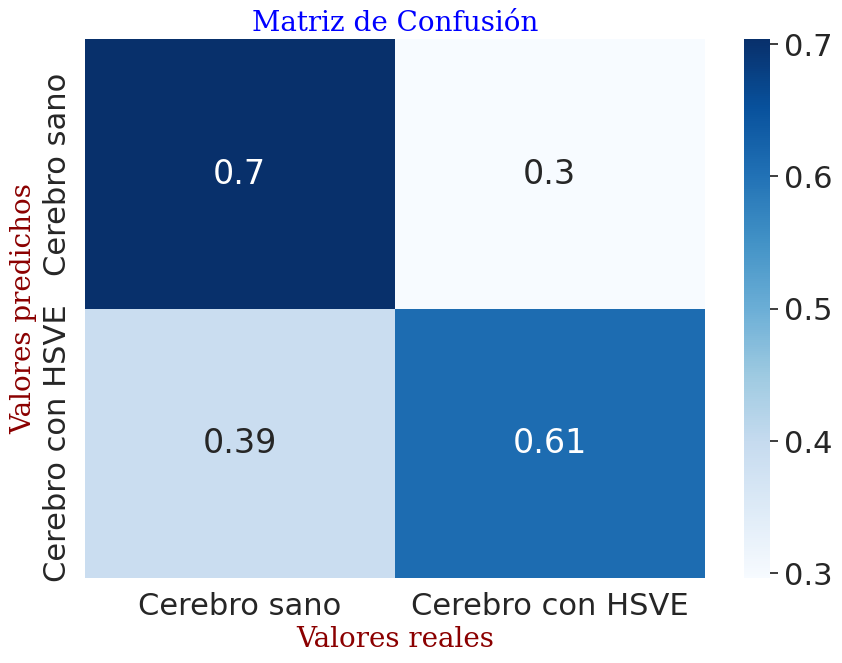

In [28]:
# Se visualiza la matriz de confusión
confusion_matrix = tf.math.confusion_matrix(preds, etiquetas)
cm = plt.figure(figsize=(10, 7))


x_axis_labels = ['Cerebro sano', 'Cerebro con HSVE'] # labels for x-axis [0, 1]
y_axis_labels = ['Cerebro sano', 'Cerebro con HSVE'] # labels for y-axis [0, 1]

sns.set(font_scale=2)

heat_map = sns.heatmap((confusion_matrix/np.sum(confusion_matrix, axis=1, keepdims=True)), annot=True, cmap="Blues",  xticklabels=x_axis_labels, yticklabels=y_axis_labels)
# Si no funciona, entonces probar con cmap=colormap, definido arriba

font1 = {'family':'serif','color':'blue','size':20}
font2 = {'family':'serif','color':'darkred','size':20}

plt.title("Matriz de Confusión", fontdict = font1)
plt.ylabel('Valores predichos', fontdict = font2)
plt.xlabel('Valores reales', fontdict = font2)

fig = heat_map.get_figure()
fig.savefig('figuras/Model1Iteration1_TestModel_ALL_TYPES_DATASET_confusion_matrix.png')

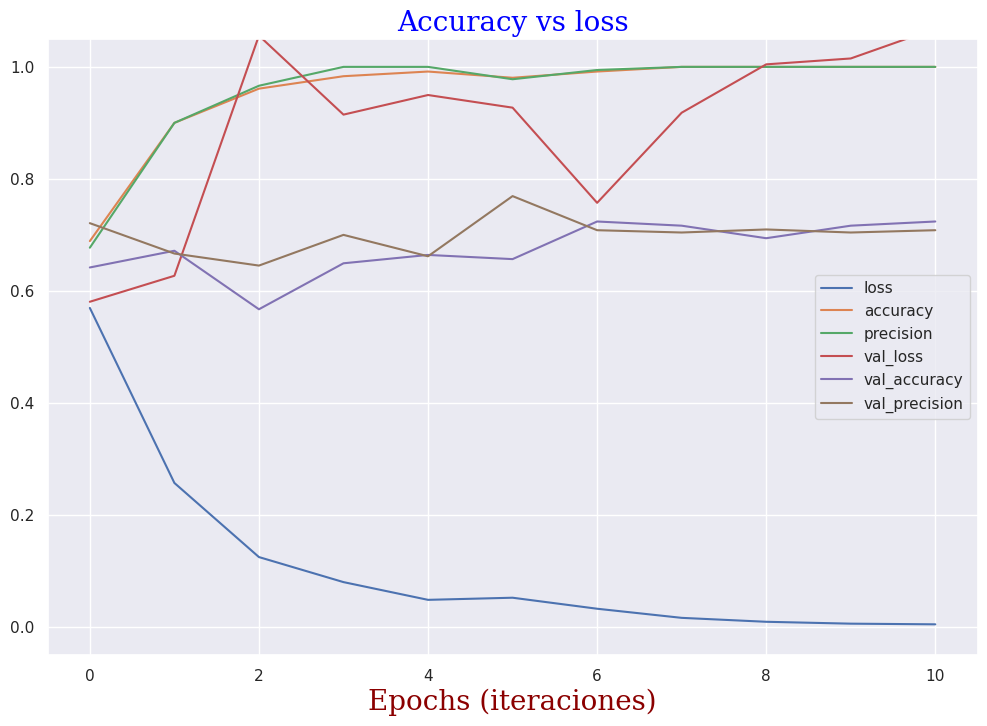

In [ ]:
# Se obtienen las métricas de exactitud y pérdida obtenida en training y validation en cada epoch del entrenamiento

sns.set(font_scale=1)
font1 = {'family':'serif','color':'blue','size':20}
font2 = {'family':'serif','color':'darkred','size':20}

figure = pd.DataFrame(h.history).plot(figsize=(12,8))
plt.ylim(-0.05, 1.05)

plt.title("Accuracy vs loss", fontdict = font1)
plt.xlabel("Epochs", fontdict = font2)

fig = figure.get_figure()
fig.savefig('figuras/Model1Iteration1_TestModel_ALL_TYPES_DATASET_accuracy_vs_loss.png')

In [ ]:

# Se obtiene la exactitud o accuracy obtenida en training y validation en cada epoch del entrenamiento
sns.set(font_scale=1)

#accuracy per epoch graph
accuracy = h.history['accuracy']
val_accuracy = h.history['val_accuracy']
epochs = h.epoch
figure = plt.figure(figsize=(6,8))
plt.title('Evolución de la exactitud (accuracy)', fontdict = font1)
plt.ylim(-0.05, 1.05)
plt.xlabel("Epochs", fontdict = font2)
plt.plot(epochs, accuracy)
plt.plot(epochs, val_accuracy)

# figure = pd.DataFrame(h.history).plot(figsize=(12,8))

fig = figure.get_figure()
fig.savefig('figuras/Model1Iteration1_TestModel_ALL_TYPES_DATASET_accuracy.png')

In [ ]:
# Se obtiene la pérdida o loss obtenida en training y validation en cada epoch del entrenamiento
loss = h.history['loss']
val_loss = h.history['val_loss']
epochs = h.epoch
figure = plt.figure(figsize=(6,8))
plt.title('Evolución de la pérdida (loss)', fontdict = font1)
plt.ylim(-0.05, 1.05)
plt.xlabel("Epochs", fontdict = font2)
plt.plot(epochs,loss)
plt.plot(epochs,val_loss)

fig = figure.get_figure()
fig.savefig('figuras/Model1Iteration1_TestModel_ALL_TYPES_DATASET_loss.png')

In [ ]:
# Se visualiza la salida de las activaciones intermedias

# get_linear_filters = K.function(inputs=model_gpu.layers[0].input, outputs=model_gpu.layers[1].output)
# get_activations = K.function(inputs=model_gpu.layers[0].input, outputs=model_gpu.layers[1].output)
# filters_applied = get_linear_filters([X_train[0:2, :, :, :],0])
# activations_output = get_activations([X_train[0:2, :, :, :],0])
#
#
# filters = plt.figure(figsize=(8,8))
# for i in range(32):
#     ax = filters.add_subplot(6, 6, i + 1)
#     ax.imshow(filters_applied[0][:, :, i], cmap = 'gray')
#     plt.xticks(np.array([]))
#     plt.yticks(np.array([]))
#     plt.tight_layout()
#
# filters.savefig('20_filters_applied')
#
# activations = plt.figure(figsize=(8,8))
# for i in range(32):
#     ax = activations.add_subplot(6, 6, i + 1)
#     ax.imshow(activations_output[0][:, :, i], cmap = 'gray')
#     plt.xticks(np.array([]))
#     plt.yticks(np.array([]))
#     plt.tight_layout()

# activations.savefig('figuras/Model1Iteration1_TestModel_ALL_TYPES_DATASET_20_activations')

# 10. EXPORTACIÓN DEL MODELO E HISTÓRICOS

In [ ]:
# Se exporta el historial con la precisión y pérdida del modelo guardado
np.save('modelos_entrenados/Model1Iteration1_TestModel_ALL_TYPES_DATASET_HISTORY.npy',h.history)

In [ ]:
# Se guarda/exporta el modelo de CNN entrenado
model_gpu.save('modelos_entrenados/Model1Iteration1_TestModel_ALL_TYPES_DATASET.h5')